In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import gym
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import deque

In [2]:
env=gym.make('Breakout-v0')

In [3]:
obs=env.reset()

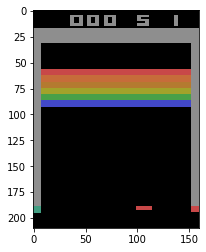

In [4]:
plt.imshow(obs)

In [5]:
import cv2 as cv

In [6]:
stacked_frames=deque(maxlen=4)

In [7]:
def preprocess_frame(frame):
    frame=frame[30:,:,:] #we cut the top of the frame to a void Misleading decision of the model.
    frame=cv.cvtColor(frame,cv.COLOR_RGB2GRAY)
    frame=frame/255.0
    return frame

def stack_frames(frame,done):
    """
    this stacks each 4 frame togother to recognise the movement in the frame
    this is technique use in alot of deep learning problem.
    
    """
    frame=preprocess_frame(frame)  
    if done:
        for i in range(4):
            stacked_frames.append(frame)
    stacked_frames.append(frame)
    input_stacks=np.stack(stacked_frames,axis=2)
    return input_stacks

In [8]:
input_shape=[180,160,4]
output_shape= env.action_space.n
epochs=1000
n_steps=200
batch_size=64
buffer_size=10000
gamma=0.95
epsilon=1

In [9]:
keras.backend.clear_session()
model=keras.models.Sequential([
    keras.layers.Conv2D(32,15,activation='elu',padding='same',input_shape=input_shape),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(64,5,activation='elu',padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(128,3,activation='elu',padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(32,activation='relu'),
    keras.layers.Dense(output_shape)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 160, 32)      28832     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 80, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 90, 80, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 80, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 40, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 45, 40, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 40, 128)       7

In [10]:
replay_buffer=deque(maxlen=buffer_size)

In [11]:
def epsilon_greedy_policy(state,epsilon):
    if np.random.rand()<epsilon:
        return np.random.randint(0,4)
    else:
        Q_value=model.predict(state[np.newaxis])
        return np.argmax(Q_value[0])

In [12]:
def sample_experiance(batch_size):
    index=np.random.randint(len(replay_buffer),size=batch_size)
    batch=[replay_buffer[i] for i in index]
    states,actions,rewards,next_states,dones=[np.array([experience[field_index] for experience in batch]) for field_index in range(5)]
    return states,actions,rewards,next_states,dones

In [13]:
def play_one_step(env,state,epsilon):
    action=epsilon_greedy_policy(state,epsilon)
    next_state,reward,done,info=env.step(action)
    next_state=stack_frames(next_state,done)
    replay_buffer.append((state,action,reward,next_state,done))
    return next_state,reward,done,info

In [14]:
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.mean_squared_error

In [15]:
def training_step():
    states,actions,rewards,next_states,dones=sample_experiance(batch_size)
    next_Q_value=model.predict(next_states)
    max_next_Q_value=np.max(next_Q_value,axis=1)
    target_Q_value=(rewards+(1-dones)*gamma*max_next_Q_value)
    
    mask=tf.one_hot(actions,output_shape)
    
    with tf.GradientTape() as tape:
        all_Q_value=model(states)
        Q_value=tf.reduce_sum(all_Q_value*mask,axis=1,keepdims=True)
        loss=tf.reduce_mean(loss_fn(Q_value,target_Q_value))
    grads=tape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(grads,model.trainable_variables))

In [16]:
def trainig_loop(env):
    for episode in tqdm(range(1,epochs)):
        state=env.reset()
        state=stack_frames(state,True)
        for step in range(n_steps):
            epsilon=max(1 - episode / 500, 0.1)
            next_state,reward,done,info=play_one_step(env,state,epsilon)
            if done:
                break
        if episode>20:
            training_step()

In [ ]:
trainig_loop(env)

  2%|▏         | 20/999 [00:25<27:44,  1.70s/it]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

